In [1]:
import warnings

# Отключаем все предупреждения
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [4]:
train

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [5]:
train[['country', 'store', 'product']].apply(lambda col: col.unique()).to_dict()

{'country': array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
       dtype=object),
 'store': array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
       dtype=object),
 'product': array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
        'Kerneler Dark Mode'], dtype=object)}

In [6]:
train[train['num_sold'].isna()]

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...,...
229905,229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229950,229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN
229995,229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN
230040,230040,2016-12-31,Canada,Discount Stickers,Holographic Goose,NaN


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


# EDA

## lineplot

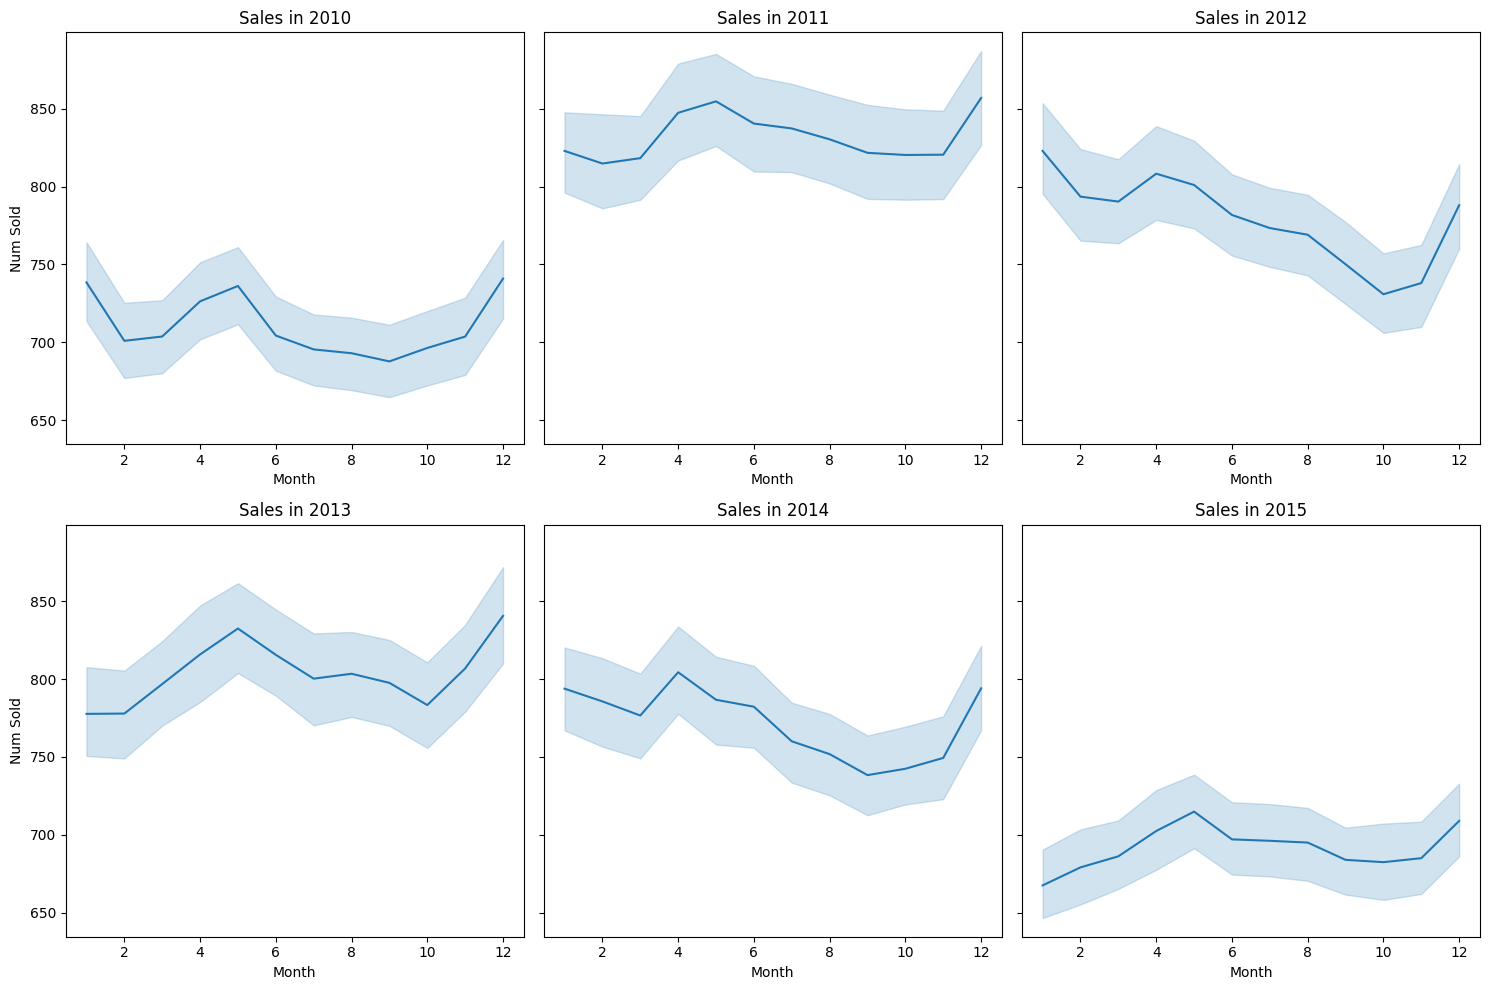

In [8]:
# Задаем параметры фигуры
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# Генерируем графики по годам
for i, year in enumerate(range(2010, 2016)):
    ax = axes[i // 3, i % 3]  # Определяем положение в сетке
    sns.lineplot(
        data=train[train['date'].dt.year == year], 
        x=train[train['date'].dt.year == year]['date'].dt.month,
        y='num_sold', 
        ax=ax
    )
    ax.set_title(f'Sales in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Num Sold')

# Очищаем и упорядочиваем
plt.tight_layout()

Text(0.5, 1.0, 'Sold Year-Product')

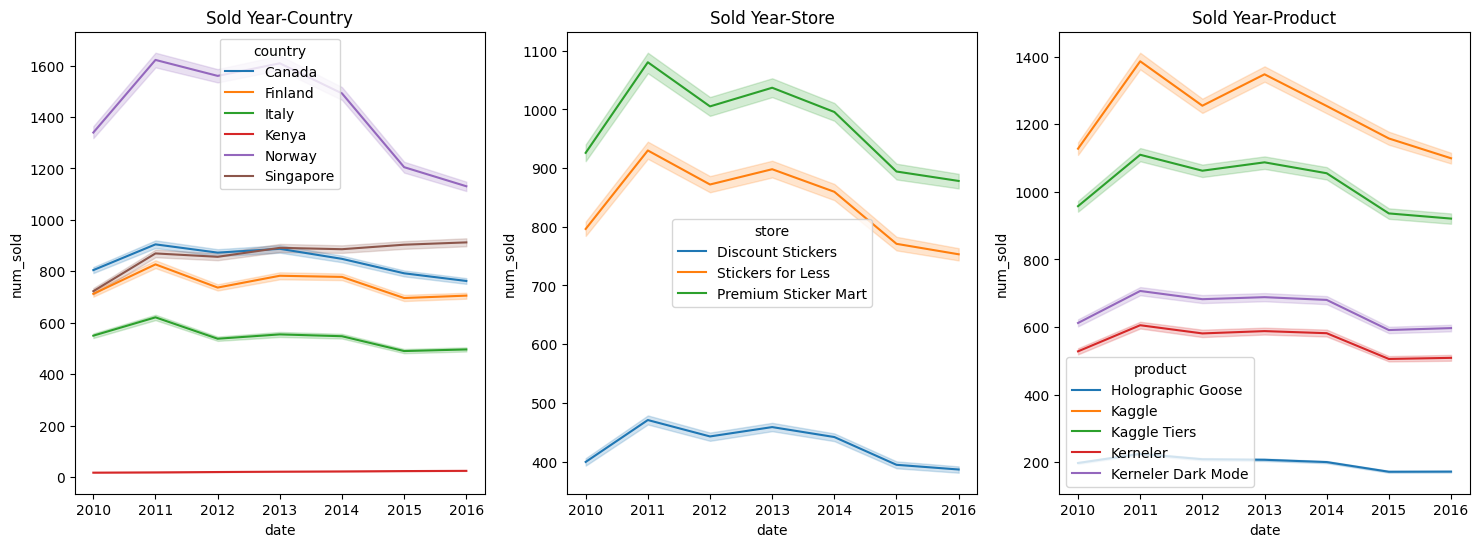

In [9]:
fit, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['country'], ax = axes[0])
axes[0].set_title('Sold Year-Country')

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['store'], ax = axes[1])
axes[1].set_title('Sold Year-Store')

sns.lineplot(data = train, x = train['date'].dt.year, y = train['num_sold'], hue = train['product'], ax = axes[2])
axes[2].set_title('Sold Year-Product')

Text(0.5, 1.0, 'Sold Month-Product')

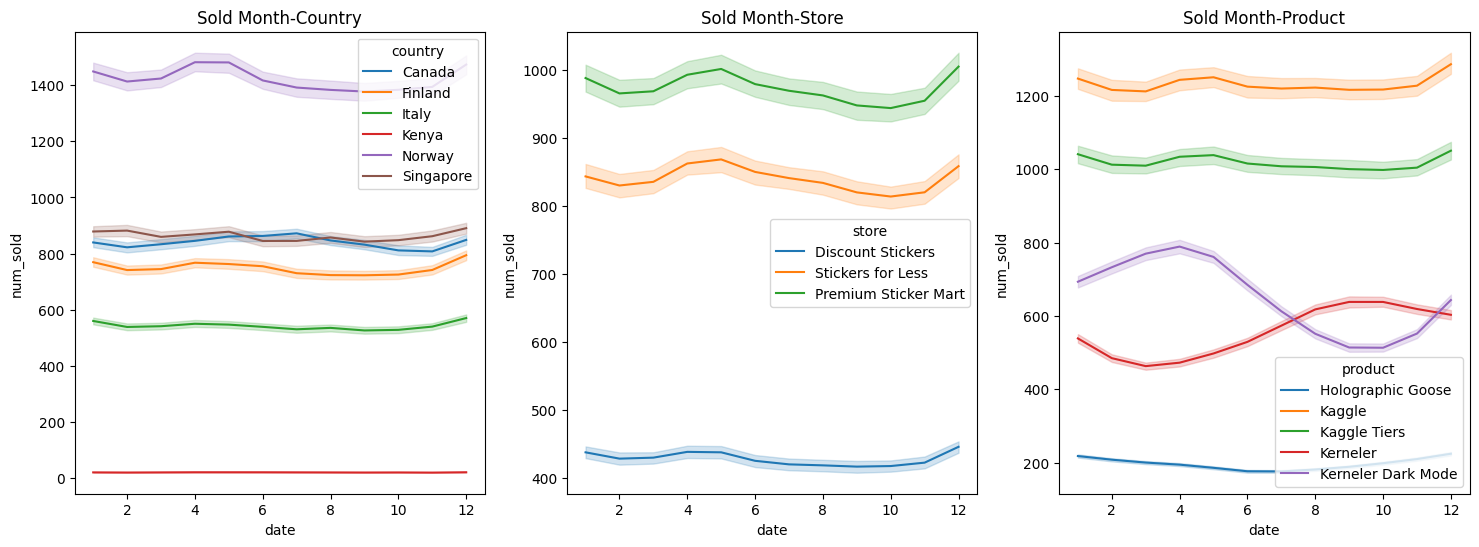

In [10]:
fit, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['country'], ax = axes[0])
axes[0].set_title('Sold Month-Country')

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['store'], ax = axes[1])
axes[1].set_title('Sold Month-Store')

sns.lineplot(data = train, x = train['date'].dt.month, y = train['num_sold'], hue = train['product'], ax = axes[2])
axes[2].set_title('Sold Month-Product')

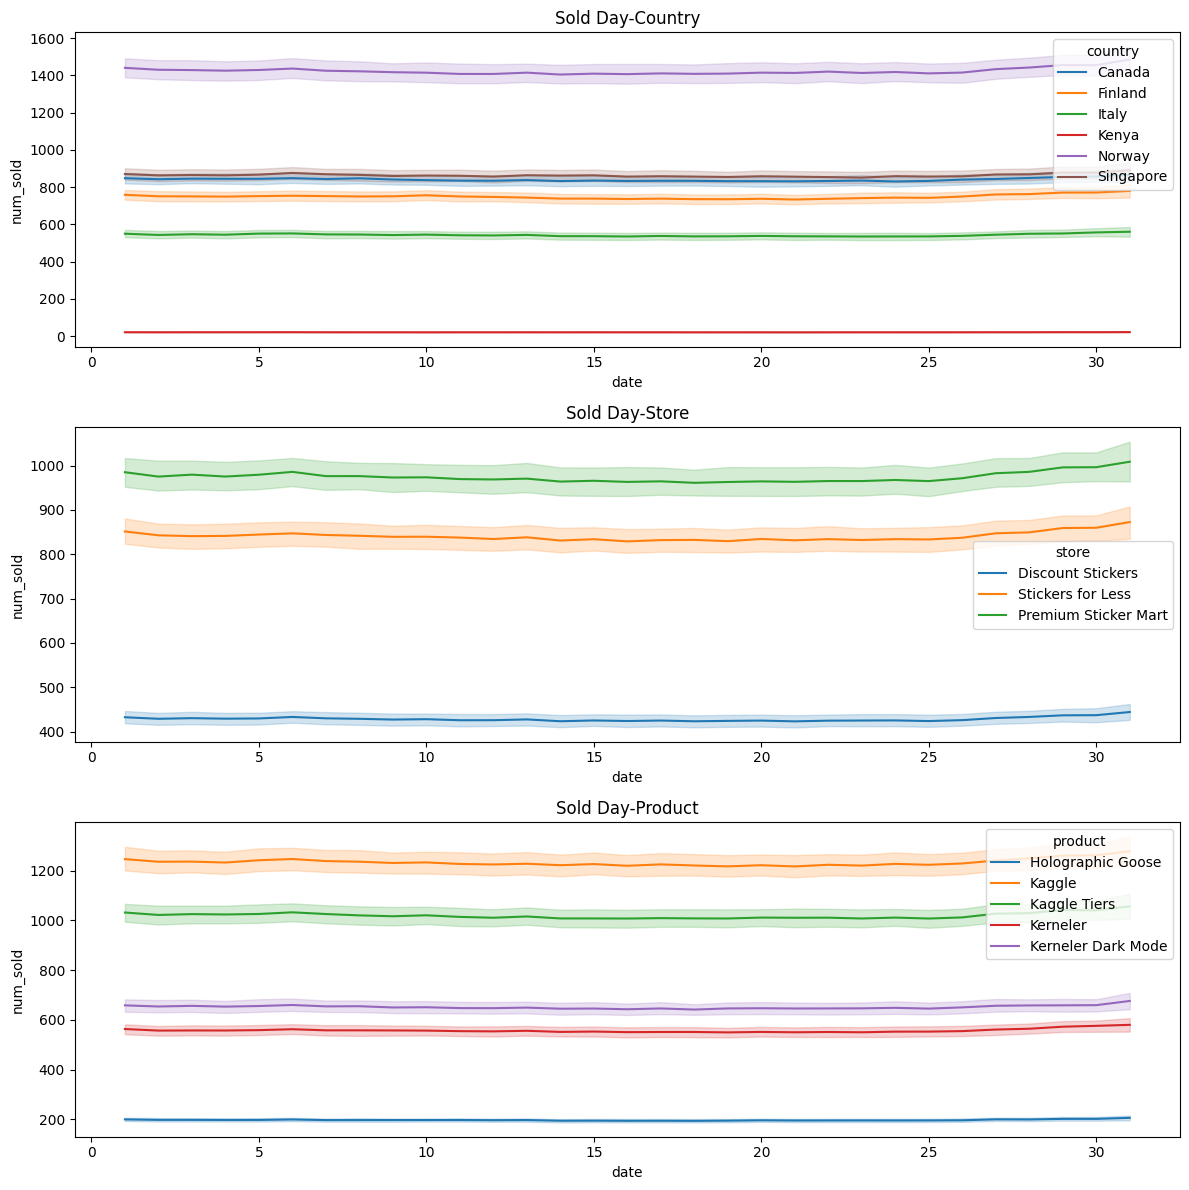

In [11]:
fit, axes = plt.subplots(3, 1, figsize=(12, 12))  # Увеличиваем высоту фигуры

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['country'], ax=axes[0])
axes[0].set_title('Sold Day-Country')

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['store'], ax=axes[1])
axes[1].set_title('Sold Day-Store')

sns.lineplot(data=train, x=train['date'].dt.day, y=train['num_sold'], hue=train['product'], ax=axes[2])
axes[2].set_title('Sold Day-Product')

# Применяем автоматическое выравнивание
plt.tight_layout()

## barplot

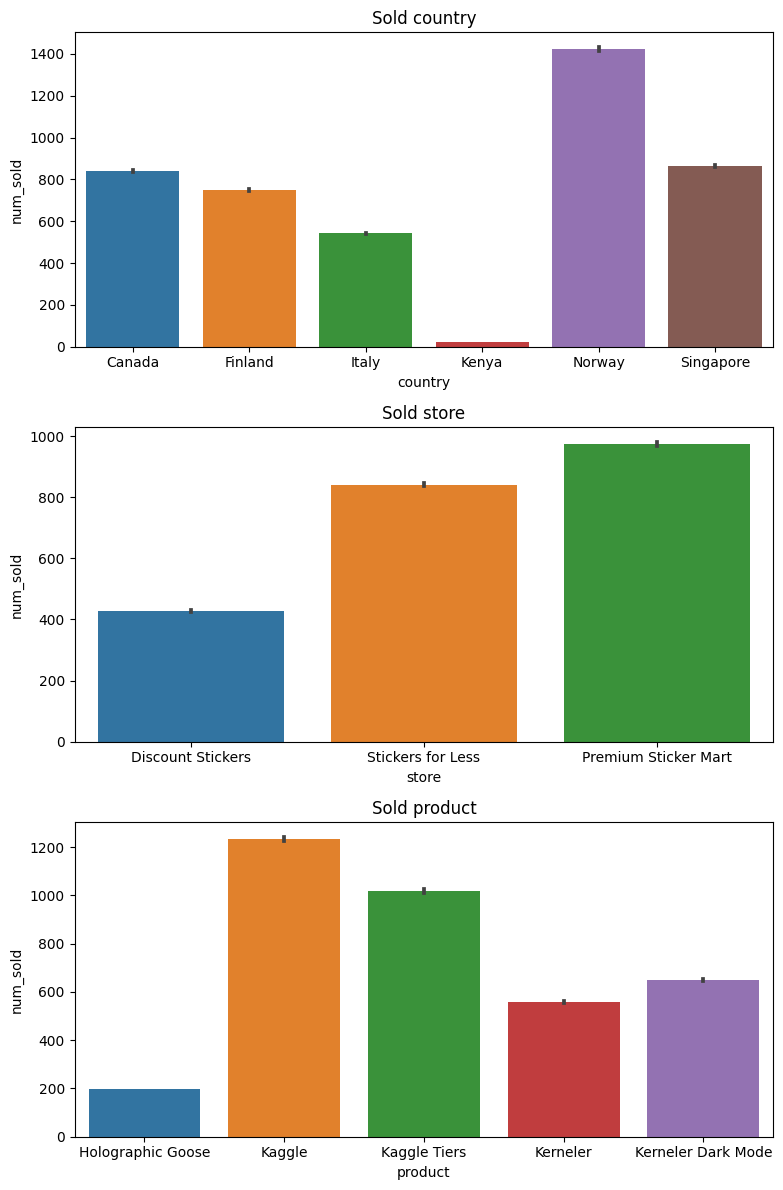

In [12]:
fig, axes = plt.subplots(3, 1, figsize = (8, 12))

sns.barplot(data = train, x = train['country'], y = train['num_sold'], ax = axes[0])
axes[0].set_title('Sold country')

sns.barplot(data = train, x = train['store'], y = train['num_sold'], ax = axes[1])
axes[1].set_title('Sold store')

sns.barplot(data = train, x = train['product'], y = train['num_sold'], ax = axes[2])
axes[2].set_title('Sold product')

plt.tight_layout()

## seasonal_decompose

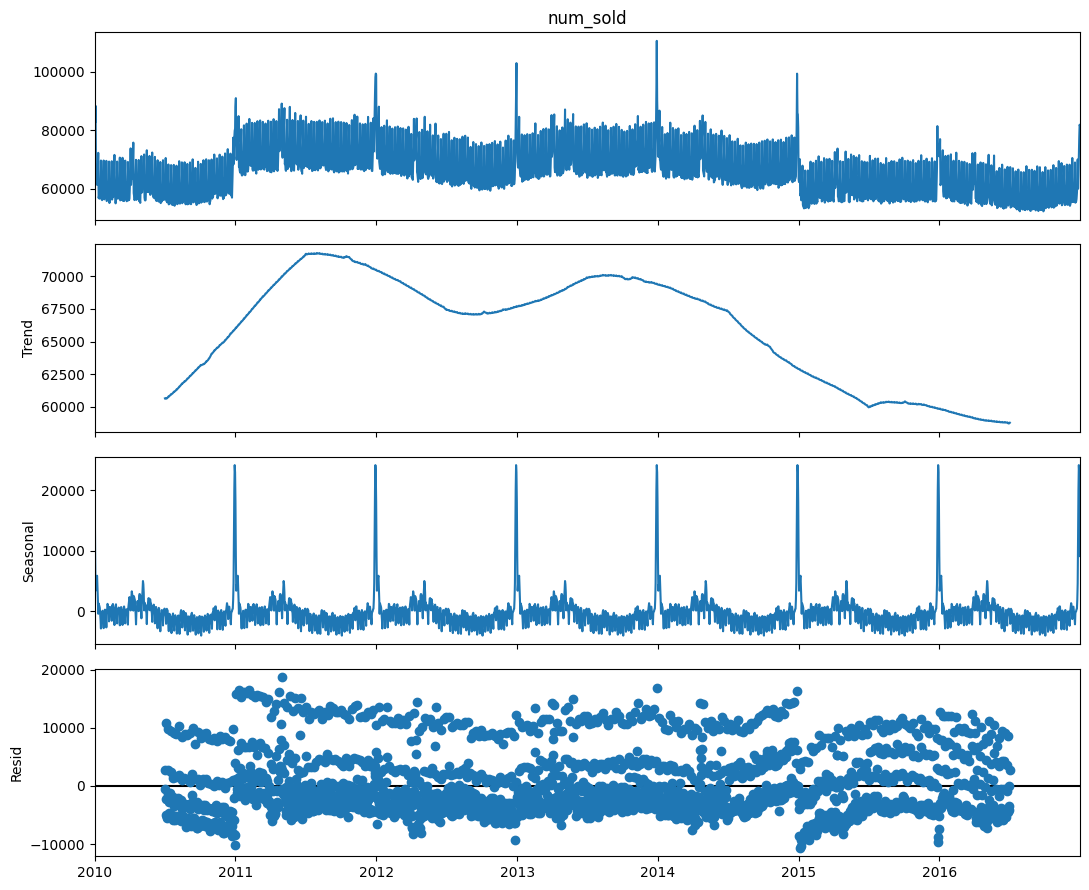

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

series = train.copy()

# Преобразуем дату в индекс и выбираем столбец
series.set_index('date', inplace=True)

# Группируем данные по индексу (дате) и агрегируем
series = series.groupby(series.index).sum()

series = series['num_sold'].asfreq('D')  # Устанавливаем дневную частоту

# Задаем размер графика
rcParams['figure.figsize'] = 11, 9

# Применяем seasonal_decompose
decompose = seasonal_decompose(series, model='additive', period=365)
decompose.plot()
plt.show()


# Model

In [14]:
pivot_data = pd.pivot_table(train, values = 'num_sold', index = 'date', columns = ['country', 'store', 'product'], fill_value = 0)

## Checking for missed days in the array

In [15]:
pivot_train = pd.pivot_table(train, values = 'num_sold', index = 'date', columns = ['country', 'store', 'product'], fill_value = 0)
pivot_test = pd.pivot_table(test, values = 'id', index = 'date', columns = ['country', 'store', 'product'], fill_value = 0)

# Генерация полного набора дат
all_train_dates = pd.date_range(start='2010-01-01', end='2016-12-31')
all_test_dates = pd.date_range(start='2017-01-01', end='2019-12-31')

# Проверка тренировочных данных
for col in pivot_train.columns:
    country, store, product = col
    sales = pivot_train[col]

    # Нахождение пропущенных дат
    missing_train_dates = set(all_train_dates) - set(sales.index)

    if missing_train_dates:
        print(f"Пропущенные даты в тренировочных данных для {country}-{store}-{product}: {sorted(missing_train_dates)}")

# Проверка тестовых данных
for col in pivot_test.columns:
    country, store, product = col
    sales = pivot_test[col]

    # Нахождение пропущенных дат
    missing_test_dates = set(all_test_dates) - set(sales.index)

    if missing_test_dates:
        print(f"Пропущенные даты в тестовых данных для {country}-{store}-{product}: {sorted(missing_test_dates)}")


In [16]:
pivot_data.head()

country               Canada                                           \
store      Discount Stickers                                            
product               Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                    
2010-01-01             973.0        906.0    423.0              491.0   
2010-01-02             881.0        854.0    440.0              437.0   
2010-01-03            1003.0        839.0    417.0              495.0   
2010-01-04             744.0        609.0    339.0              441.0   
2010-01-05             707.0        640.0    290.0              372.0   

country                                                        \
store      Premium Sticker Mart                                 
product       Holographic Goose  Kaggle Kaggle Tiers Kerneler   
date                                                            
2010-01-01                375.0  2212.0       2013.0    950.0   
2010-01-02                336.0  2183.0       1953.0    895.0   
2010-01-03                338.0  2459.0       1938.0   1015.0   
2010-01-04                277.0  1714.0       1567.0    802.0   
2010-01-05                287.0  1593.0       1590.0    773.0   

country                                          ...            Singapore  \
store                         Stickers for Less  ... Premium Sticker Mart   
product    Kerneler Dark Mode Holographic Goose  ...    Holographic Goose   
date                                             ...                        
2010-01-01             1213.0             300.0  ...                317.0   
2010-01-02             1217.0             281.0  ...                364.0   
2010-01-03             1188.0             297.0  ...                388.0   
2010-01-04             1046.0             235.0  ...                269.0   
2010-01-05              894.0             240.0  ...                264.0   

country                                                                        \
store                                                       Stickers for Less   
product     Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode Holographic Goose   
date                                                                            
2010-01-01  2112.0       1992.0   1045.0             1255.0             301.0   
2010-01-02  2322.0       1938.0   1010.0             1224.0             268.0   
2010-01-03  2253.0       2315.0   1040.0             1314.0             289.0   
2010-01-04  1760.0       1656.0    846.0              927.0             256.0   
2010-01-05  1536.0       1410.0    770.0              962.0             226.0   

country                                                      
store                                                        
product     Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode  
date                                                         
2010-01-01  1981.0       1565.0    841.0             1080.0  
2010-01-02  1763.0       1689.0    781.0              971.0  
2010-01-03  1801.0       1690.0    813.0              987.0  
2010-01-04  1543.0       1205.0    602.0              839.0  
2010-01-05  1364.0       1352.0    629.0              795.0  

[5 rows x 88 columns]

## Forecasting

In [17]:
# Список для хранения результатов
all_results = []

# Прогнозирование для каждой серии данных
for col in pivot_data.columns:
    country, store, product = col
    sales = pivot_data[col]

    # Используем данные до 2016 года
    train_data = sales.loc[:'2016']
    
    # Модель ExponentialSmoothing
    model = ExponentialSmoothing(
        np.sqrt(train_data),  # Корень для сглаживания
        trend='add',
        seasonal='add',  # Сезонная компонента
        seasonal_periods=365  # Годовая сезонность
    )
    fit = model.fit()

    # Прогноз на 3 года (2017-2019)
    steps = len(pd.date_range(start='2017-01-01', end='2019-12-31'))  # Общее число дней за 3 года
    forecast = fit.forecast(steps=steps) ** 2  # Обратное преобразование после корня

    # Сохраняем результаты
    forecast_dates = pd.date_range(start='2017-01-01', end='2019-12-31')
    all_results.append(pd.DataFrame({
        'date': forecast_dates,
        'country': country,
        'store': store,
        'product': product,
        'forecast_num_sold': forecast
    }))

# Объединяем результаты всех прогнозов
all_results = pd.concat(all_results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

## submission

In [18]:
# Подготовка файла для Kaggle
final_submission = test.merge(
    all_results,
    on=['date', 'country', 'store', 'product'],
    how='left'
)[['id', 'forecast_num_sold']].rename(columns={'forecast_num_sold': 'num_sold'}).fillna(0)

# Сохраняем результат
final_submission.to_csv('submission.csv', index=False)

In [19]:
final_submission

,id,num_sold
0,230130,0.000000
1,230131,710.586198
2,230132,557.743570
3,230133,311.141725
4,230134,371.370584
...,...,...
98545,328675,419.392548
98546,328676,4363.463590
98547,328677,1780.378594
98548,328678,1204.512110


## Testing the model based on the 2016 forecast

In [20]:
# Список для хранения результатов
all_results = []


for col in pivot_data.columns:
    country, store, product = col
    sales = pivot_data[col]

    # Срезы для кросс-валидации
    train_data = sales.loc[:'2015']  # Данные до конца 2015 года
    test_data = sales.loc['2016']   # Фактические данные за 2016 год
    
    # Модель ExponentialSmoothing
    model = ExponentialSmoothing(
        np.sqrt(train_data),
        trend='add',
        seasonal='add',
        seasonal_periods=365,
    )
    
    # Обучаем модель
    fit = model.fit()
    
    # Прогнозируем на 2016 год
    forecast = fit.forecast(steps=len(test_data)) ** 2
    
    # Вычисляем ошибки на 2016 году
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    mape = mean_absolute_percentage_error(test_data, forecast)


    all_results.append(pd.DataFrame({
        'date' : forecast.index,
        'country' : country,
        'store' : store,
        'product' : product,     
        'forecast_num_sold' : forecast 
    }))


print(f'MAE 2016: {mae}')
print(f'RMSE 2016: {rmse}')
print(f'MAPE 2016: {mape}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MAE 2016: 81.35599391519656
RMSE 2016: 109.20909525634852
MAPE 2016: 0.08372810368435993


Text(0.5, 1.0, 'Fact vs Forecst 2016')

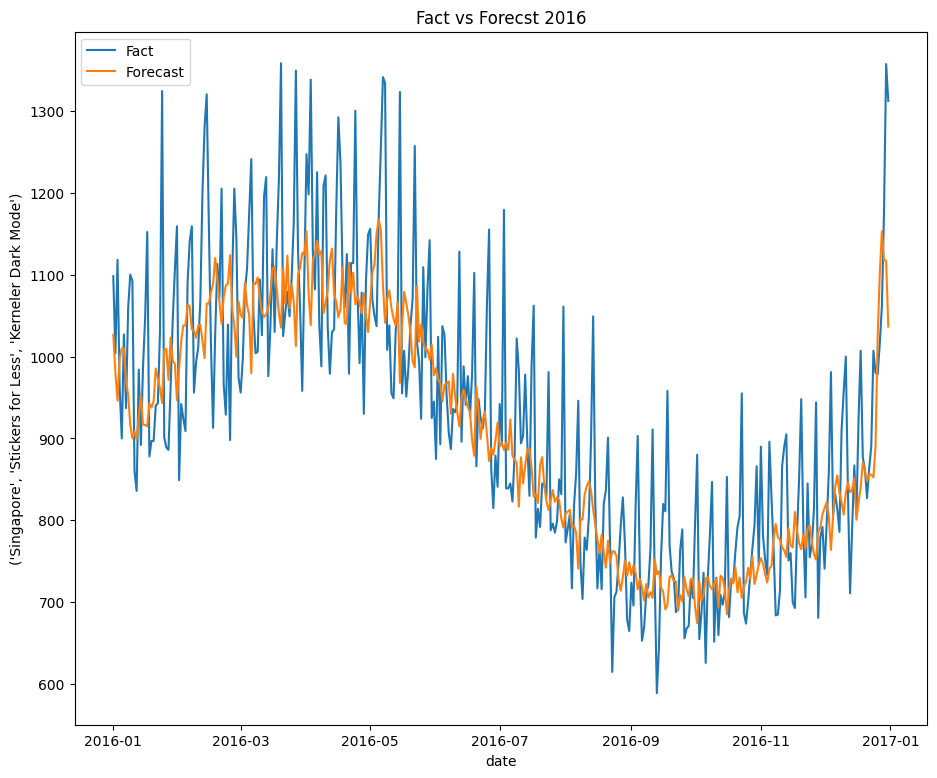

In [21]:
sns.lineplot(test_data, label = 'Fact')
sns.lineplot(forecast, label = 'Forecast')
plt.title('Fact vs Forecst 2016')